## RF in Sewer Pipes - Free Space Propagation Modelling

There are several zones in a lossy waveguide, depending on the predominant mode of EM wave propagation. When the separation between a transmitter and a receiver is short enough, the link can be modelled as a free space one. This separation is dependent on the pipe diameter, frequency of operation, and how much of the first Fresnel zone we want to be unobstructed.

Another restriction is that the separation between the transmitter and the receiver has to be such that they are in each other's far field regions. This is dependent on the antenna size, unlike the maximum possible separation.

The maximum distance at which the link can be approximated as a free-space one is therefore the shorter of the two distances mentioned above.

In [10]:
import numpy as np
from scipy.constants import speed_of_light

import matplotlib.pyplot as plt
from matplotlib import ticker, colors, cm

In [11]:
def max_antenna_separation(pipe_diameter, wavelength, mode='normal'):
    pipe_radius = pipe_diameter / 2.0

    # Assume the pipe radius is 60% of the first Fresnel zone as opposed to 100%
    if mode == 'cheeky':
        pipe_radius /= 0.6
    
    separation = 16 * np.power(pipe_radius, 2) - np.power(wavelength, 2)
    separation /= (8 * wavelength)
    
    return separation


def far_field_distance(antenna_dimension, wavelength, antenna_type='monopole'):
    # A monopole is assumed to be a quarter-wavelength resonator, and
    # a dipole to be a half-wavelength resonator
    if antenna_type == 'monopole':
        dimension = wavelength / 4.0
    elif antenna_type == 'dipole':
        dimension = wavelength / 2.0
    else:
        dimension = antenna_dimension
    
    distance = 2 * np.power(dimension, 2)
    distance /= wavelength
    
    return distance


def max_antenna_separation_approx(pipe_diameter, wavelength, mode='normal'):
    pipe_radius = pipe_diameter / 2.0

    # Assume the pipe radius is 60% of the first Fresnel zone as opposed to 100%
    if mode == 'cheeky':
        pipe_radius /= 0.6

    separation = 2 * np.float_power(pipe_radius, 2)
    separation /= wavelength

    return separation

In [12]:
# Consider pipe diameters from 10 mm (1e-2 m) to 10 000 mm (10 m)
pipe_diameters = np.logspace(-2, 1, 301)

# Consider frequencies from 0.1 GHz (1e8 Hz) to 1 000 GHz (1e12 Hz)
freqs = np.logspace(8, 12, 401)
wavelengths = speed_of_light / freqs

In [13]:
max_separations_normal = np.zeros((np.size(wavelengths), np.size(pipe_diameters)))
max_separations_cheeky = np.zeros((np.size(wavelengths), np.size(pipe_diameters)))

for i, wavelength in enumerate(wavelengths):
    for j, diameter in enumerate(pipe_diameters):
        max_separations_normal[i, j] = max_antenna_separation(diameter, wavelength)
        max_separations_cheeky[i, j] = max_antenna_separation(diameter, wavelength, mode='cheeky')

In [14]:
far_field_monopole = np.zeros(801)
far_field_dipole = np.zeros(801)
far_field_2x2 = np.zeros(801)
far_field_4x4 = np.zeros(801)

for i, wavelength in enumerate(wavelengths):
    far_field_monopole[i] = far_field_distance(_, wavelength, 'monopole')
    far_field_dipole[i] = far_field_distance(_, wavelength, 'dipole')
    far_field_2x2[i] = far_field_distance(wavelength, wavelength, 'array')
    far_field_4x4[i] = far_field_distance(2*wavelength, wavelength, 'array')

In [15]:
# Mask distances smaller than zero, as a) they have no physical meaning, and b) the `log` function will be sad
# The masking can be extended to other distances, e.g. impose a minimum separation of 1 metre between antennas
max_separations_normal_ma = np.ma.masked_where(max_separations_normal <= 1.0, max_separations_normal)
max_separations_cheeky_ma = np.ma.masked_where(max_separations_cheeky <= 1.0, max_separations_cheeky)
xv, yv = np.meshgrid(freqs, pipe_diameters, indexing='ij')

Text(0, 0.5, 'Pipe diameter, (m)')

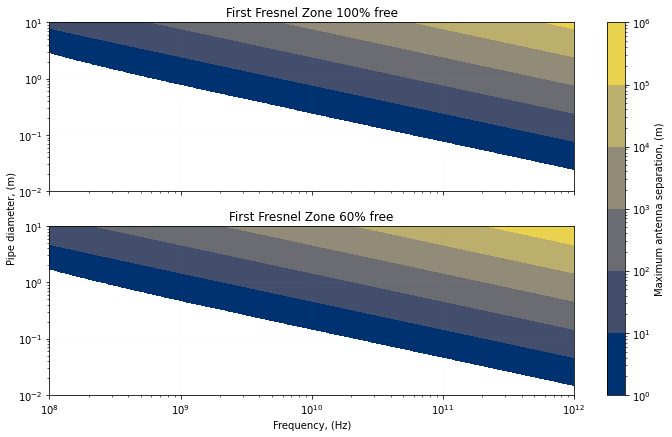

In [16]:
plt.rc('legend', fontsize=8)
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.set_size_inches(10, 10/1.618)

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(np.min(freqs), np.max(freqs))
axes[0].set_ylim(np.min(pipe_diameters), np.max(pipe_diameters))
contour = axes[0].contourf(xv, yv, max_separations_normal_ma, norm=colors.LogNorm(), cmap='cividis')
# axes[0].loglog(freqs, far_field_monopole, label='Monopole Far-Field Limit', lw=0.5)
# axes[0].loglog(freqs, far_field_dipole, label='Dipole Far-Field Limit', lw=0.5)
# axes[0].loglog(freqs, far_field_2x2, label='2x2 Far-Field Limit', lw=0.5)
# axes[0].loglog(freqs, far_field_4x4, label='4x4 Far-Field Limit', lw=0.5)
axes[0].grid(which='major', lw=0.05)
# axes[0].legend(loc='lower left')

axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlim(np.min(freqs), np.max(freqs))
axes[1].set_ylim(np.min(pipe_diameters), np.max(pipe_diameters))
contour = axes[1].contourf(xv, yv, max_separations_cheeky_ma, norm=colors.LogNorm(), cmap='cividis')
# axes[1].loglog(freqs, far_field_monopole, label='Monopole Far-Field Limit', lw=0.5)
# axes[1].loglog(freqs, far_field_dipole, label='Dipole Far-Field Limit', lw=0.5)
# axes[1].loglog(freqs, far_field_2x2, label='2x2 Far-Field Limit', lw=0.5)
# axes[1].loglog(freqs, far_field_4x4, label='4x4 Far-Field Limit', lw=0.5)
axes[1].grid(which='major', lw=0.05)
# axes[1].legend(loc='lower left')

axes[0].set_title('First Fresnel Zone 100% free')
axes[1].set_title('First Fresnel Zone 60% free')
axes[1].set_xlabel('Frequency, (Hz)')

fig.tight_layout()

cbar = fig.colorbar(contour, ax=axes.ravel().tolist())
cbar.set_label('Maximum antenna separation, (m)')

fig.text(0, 0.5, 'Pipe diameter, (m)', va='center', rotation='vertical')

# fig.savefig('distance_vs_freq_and_diameter.pdf', bbox_inches='tight')
# fig.savefig('Free Space Propagation Distance in Pipes Approx.png', bbox_inches='tight', dpi=600)